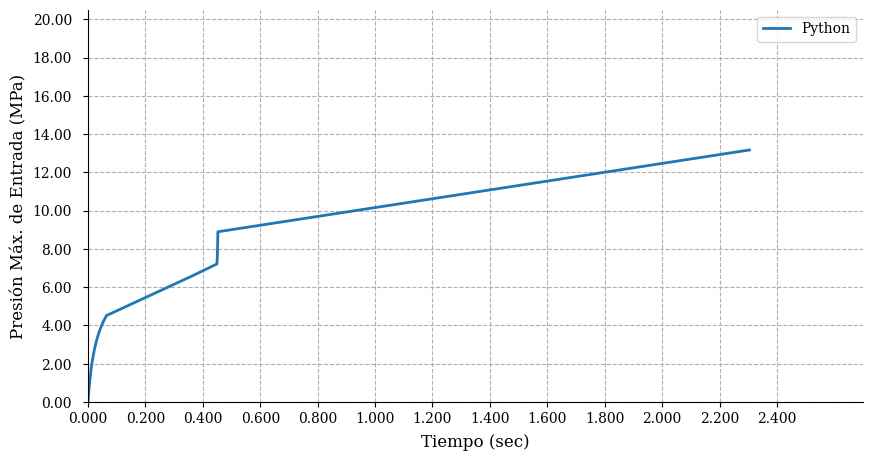

Pressure drop for sprue: 4.51 MPa
Pressure drop for main runner: 1.90 MPa
Pressure drop for secondary runner: 0.79 MPa
Pressure drop for gate: 1.69 MPa
Pressure drop for part: 4.27 MPa


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

def configure_matplotlib():
    """Configure matplotlib settings."""
    plt.rcParams.update({
        "text.usetex": False,
        "font.family": "serif",
        "mathtext.fontset": "cm",
    })

def convert_units(Qcc_inlet, cavidades):
    """Convert units from mm to m and cc/s to m^3/s."""
    return {
        'length_sprue_m': length_sprue_mm / 1000.0,
        'Q_m3_sprue': Qcc_inlet * 1e-6,
        'length_main_runner_m': length_main_runner_mm / 1000.0,
        'Q_m3_main_runner': (Qcc_inlet * 0.50 * (0.75/1.00)) * 1e-6,
        'length_secondary_runner_m': length_secondary_runner_mm / 1000.0,
        'Q_m3_secondary_runner': (Qcc_inlet  * (0.75/1.00) / 20.0) * 1e-6,
        'length_gate_m': length_gate_mm / 1000.0,
        'Q_m3_gate': (Qcc_inlet / 20.0) * 1e-6,
        'length_part_m': length_part_mm / 1000.0,
        'Q_m3_part': (Qcc_inlet * 1e-6 / cavidades),
    }

def local_radius_mm_sprue(x, r_in_mm, r_out_mm, length_m):
    """Compute the local radius in mm at position x for the sprue."""
    return r_in_mm + (r_out_mm - r_in_mm) * (x / length_m)

def local_radius_mm_runner(x, R_runner):
    """Compute the local radius in mm for the runner (constant radius)."""
    return R_runner

def local_radius_mm_secondary_runner(x, R_secondary_runner):
    """Compute the local radius in mm for the secondary runner (constant radius)."""
    return R_secondary_runner

def local_radius_mm_gate(x, r_in_mm, r_out_mm, length_m):
    """Compute the local radius in mm at position x for the gate."""
    return r_in_mm + (r_out_mm - r_in_mm) * (x / length_m)

def calculate_pressure_and_time(Q_m3, length_m, local_radius_mm_func, params, is_part=False):
    """Calculate pressure drop and time for a given pipe."""
    x_array = np.linspace(0, length_m, N)
    dx = x_array[1] - x_array[0]
    time_array = np.zeros_like(x_array)
    pressure_array = np.zeros_like(x_array)

    for i in range(1, N):
        x_mid = 0.5 * (x_array[i-1] + x_array[i])
        
        if is_part:
            # Using the provided formula for part pressure drop
            Wpart = (13.50 - 3.50) * 1e-3
            Hpart = 2.00 * 1e-3
            Lpart = length_m * 1e-3
            Qpart = Q_m3
            
            dP = 2 * k_sprue * (Lpart / Hpart) * (2 * (2 + (1 / n_sprue)) * Qpart / (Wpart * Hpart**2)) ** n_sprue
            dt = dx / (Qpart / (Wpart * Hpart))
        else:
            R_mid_mm = local_radius_mm_func(x_mid, **params)
            R_mid_m = R_mid_mm / 1000.0
            A_mid = np.pi * (R_mid_m)**2
            v_mid = Q_m3 / A_mid
            dt = dx / v_mid
            dx_mm = dx * 1000.0
            term = ((3 + 1/n_sprue) * Q_m3) / (np.pi * (R_mid_mm * 1e-3)**3)
            dP = 2 * k_sprue * (dx_mm / R_mid_mm) * (term ** n_sprue)
        
        time_array[i] = time_array[i-1] + dt
        pressure_array[i] = pressure_array[i-1] + dP

    pressure_array_MPa = pressure_array * 1e-6
    return time_array, pressure_array_MPa

def plot_pressure_vs_time(time_combined, pressure_combined):
    """Plot Pressure vs Time for combined sprue, main runner, secondary runner, gate, and part."""
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(time_combined, pressure_combined, lw=2, label='Python')
    ax.set_xlabel('Tiempo (sec)', fontsize=12, labelpad=6)
    ax.set_ylabel('Presión Máx. de Entrada (MPa)', fontsize=12, labelpad=4)
    ax.set_xlim(0, 2.70)
    ax.set_ylim(0, 20.5)
    ax.set_xticks(np.arange(0, 2.55, 0.2))
    ax.set_yticks(np.arange(0, 20.50, 2.0))
    ax.grid(True, ls='--')
    ax.legend()

    # Format Y axis to 2 decimals, X axis to 3 decimals
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.tick_params(axis='y', pad=8)  # Try 0 or negative values for more left

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_aspect((2/3)*(0.2/2))
    plt.savefig('Presión en la Entrada.png', dpi=100, bbox_inches='tight', transparent=False)
    plt.show()

# Constants
Qcc_inlet = 21.60
k_sprue = 5300
n_sprue = 0.378
length_sprue_mm = 60.00
r_in_sprue_mm = 4.00 / 2.0
r_out_sprue_mm = 6.75 / 2.0
length_main_runner_mm = 63.00
r_main_runner_mm = 3.35
length_secondary_runner_mm = 12.00
r_secondary_runner_mm = 1.54
length_gate_mm = 3.00
p_in_gate_mm = 4.66
p_out_gate_mm = 3.00
length_part_mm = 100.00
N = 1000
cavidades = 20  # Assuming 20 cavities based on your flow rate division

# Configure matplotlib
configure_matplotlib()

# Convert units
units = convert_units(Qcc_inlet, cavidades)

# Calculate for sprue
params_sprue = {'r_in_mm': r_in_sprue_mm, 'r_out_mm': r_out_sprue_mm, 'length_m': units['length_sprue_m']}
time_sprue, pressure_sprue = calculate_pressure_and_time(units['Q_m3_sprue'], units['length_sprue_m'], local_radius_mm_sprue, params_sprue)

# Calculate for main runner
params_main_runner = {'R_runner': r_main_runner_mm}
time_main_runner, pressure_main_runner = calculate_pressure_and_time(units['Q_m3_main_runner'], units['length_main_runner_m'], local_radius_mm_runner, params_main_runner)

# Calculate for secondary runner
params_secondary_runner = {'R_secondary_runner': r_secondary_runner_mm}
time_secondary_runner, pressure_secondary_runner = calculate_pressure_and_time(units['Q_m3_secondary_runner'], units['length_secondary_runner_m'], local_radius_mm_secondary_runner, params_secondary_runner)

# Calculate for gate with varying perimeter
r_in_gate = p_in_gate_mm / (2 * np.pi)
r_out_gate = p_out_gate_mm / (2 * np.pi)
params_gate = {'r_in_mm': r_in_gate, 'r_out_mm': r_out_gate, 'length_m': units['length_gate_m']}
time_gate, pressure_gate = calculate_pressure_and_time(units['Q_m3_gate'], units['length_gate_m'], local_radius_mm_gate, params_gate)

# Calculate for part
time_part, pressure_part = calculate_pressure_and_time(units['Q_m3_part'], units['length_part_m'], None, None, is_part=True)

# Concatenate all data
time_combined = np.concatenate((
    time_sprue,
    time_sprue[-1] + time_main_runner,
    time_sprue[-1] + time_main_runner[-1] + time_secondary_runner,
    time_sprue[-1] + time_main_runner[-1] + time_secondary_runner[-1] + time_gate,
    time_sprue[-1] + time_main_runner[-1] + time_secondary_runner[-1] + time_gate[-1] + time_part
))
pressure_combined = np.concatenate((
    pressure_sprue,
    pressure_sprue[-1] + pressure_main_runner,
    pressure_sprue[-1] + pressure_main_runner[-1] + pressure_secondary_runner,
    pressure_sprue[-1] + pressure_main_runner[-1] + pressure_secondary_runner[-1] + pressure_gate,
    pressure_sprue[-1] + pressure_main_runner[-1] + pressure_secondary_runner[-1] + pressure_gate[-1] + pressure_part
))

# After time_combined and pressure_combined are defined, add:
output_df = pd.DataFrame({
    'time': time_combined,
    'pressure': pressure_combined
})

# Export to CSV
output_df.to_csv('Valor teórico.csv', index=False)

# Plot results
plot_pressure_vs_time(time_combined, pressure_combined)

# Calculate for sprue
params_sprue = {'r_in_mm': r_in_sprue_mm, 'r_out_mm': r_out_sprue_mm, 'length_m': units['length_sprue_m']}
time_sprue, pressure_sprue = calculate_pressure_and_time(units['Q_m3_sprue'], units['length_sprue_m'], local_radius_mm_sprue, params_sprue)
print(f"Pressure drop for sprue: {pressure_sprue[-1]:.2f} MPa")
accumulated_pressure_sprue = pressure_sprue[-1]

# Calculate for main runner
params_main_runner = {'R_runner': r_main_runner_mm}
time_main_runner, pressure_main_runner = calculate_pressure_and_time(units['Q_m3_main_runner'], units['length_main_runner_m'], local_radius_mm_runner, params_main_runner)
print(f"Pressure drop for main runner: {pressure_main_runner[-1]:.2f} MPa")
accumulated_pressure_main_runner = accumulated_pressure_sprue

# Calculate for secondary runner
params_secondary_runner = {'R_secondary_runner': r_secondary_runner_mm}
time_secondary_runner, pressure_secondary_runner = calculate_pressure_and_time(units['Q_m3_secondary_runner'], units['length_secondary_runner_m'], local_radius_mm_secondary_runner, params_secondary_runner)
print(f"Pressure drop for secondary runner: {pressure_secondary_runner[-1]:.2f} MPa")
accumulated_pressure_secondary_runner = accumulated_pressure_main_runner + pressure_secondary_runner[-1]

# Calculate for gate with varying perimeter
r_in_gate = p_in_gate_mm / (2 * np.pi)
r_out_gate = p_out_gate_mm / (2 * np.pi)
params_gate = {'r_in_mm': r_in_gate, 'r_out_mm': r_out_gate, 'length_m': units['length_gate_m']}
time_gate, pressure_gate = calculate_pressure_and_time(units['Q_m3_gate'], units['length_gate_m'], local_radius_mm_gate, params_gate)
print(f"Pressure drop for gate: {pressure_gate[-1]:.2f} MPa")
accumulated_pressure_gate = accumulated_pressure_secondary_runner + pressure_gate[-1]

# Calculate for part
time_part, pressure_part = calculate_pressure_and_time(units['Q_m3_part'], units['length_part_m'], None, None, is_part=True)
print(f"Pressure drop for part: {pressure_part[-1]:.2f} MPa")
accumulated_pressure_part = accumulated_pressure_gate + pressure_part[-1]

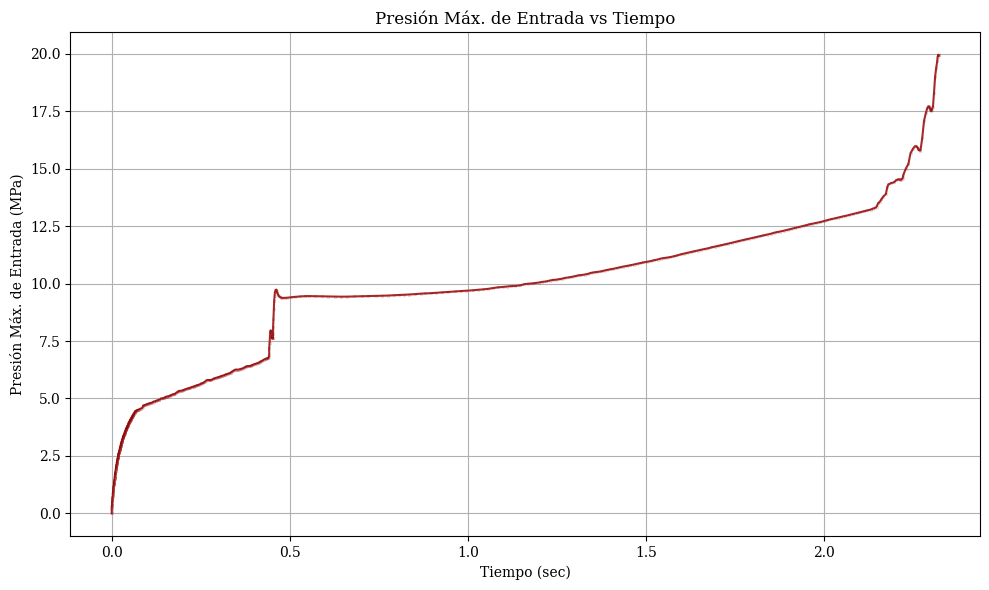

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file with correct encoding
file_path = "Default-Presión Máx. de Entrada (MPa).csv"
df = pd.read_csv(file_path, encoding='latin1')

# Clean column names
df.columns = [col.strip() for col in df.columns]
df.columns = ["Tiempo (sec)", "Presión Máx. de Entrada (MPa)"]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df["Tiempo (sec)"], df["Presión Máx. de Entrada (MPa)"], marker='o', linestyle='-', color='brown', markersize=.1, markerfacecolor='firebrick', markeredgecolor='darkred', markeredgewidth=2)
plt.title("Presión Máx. de Entrada vs Tiempo")
plt.xlabel("Tiempo (sec)")
plt.ylabel("Presión Máx. de Entrada (MPa)")
plt.grid(True)
plt.tight_layout()
plt.savefig('Solid plot.png', dpi=100, bbox_inches='tight', transparent=False)
plt.show()


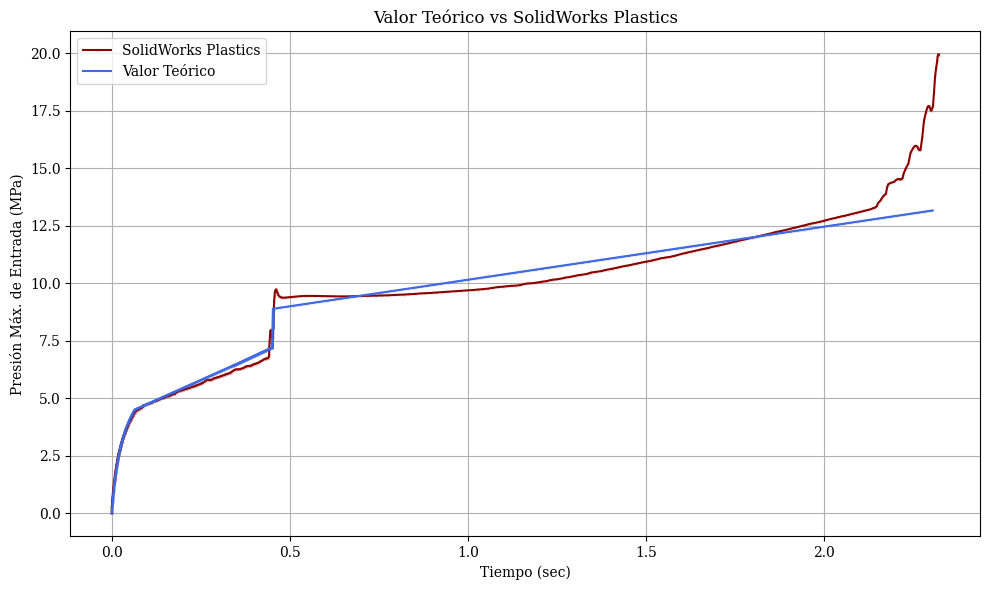

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths (update these as needed)
file_path1 = "Default-Presión Máx. de Entrada (MPa).csv"
file_path2 = "Valor teórico.csv"

# Read both CSVs
df2 = pd.read_csv(file_path1, encoding='latin1')
df1 = pd.read_csv(file_path2, encoding='latin1')

# Clean column names for both
df1.columns = [col.strip() for col in df1.columns]
df2.columns = [col.strip() for col in df2.columns]
df1.columns = ["Tiempo (sec)", "Presión Máx. de Entrada (MPa)"]
df2.columns = ["Tiempo (sec)", "Presión Máx. de Entrada (MPa)"]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df2["Tiempo (sec)"], df2["Presión Máx. de Entrada (MPa)"], 
         marker='x', linestyle='-', color='darkred', markersize=2,
         markerfacecolor='blue', markeredgecolor='darkred', markeredgewidth=.1,
         label='SolidWorks Plastics')
plt.plot(df1["Tiempo (sec)"], df1["Presión Máx. de Entrada (MPa)"], 
         marker='x', linestyle='-', color='royalblue', markersize=1,
         markerfacecolor='firebrick', markeredgecolor='royalblue', markeredgewidth=.1, 
         label='Valor Teórico')


plt.title("Valor Teórico vs SolidWorks Plastics")
plt.xlabel("Tiempo (sec)")
plt.ylabel("Presión Máx. de Entrada (MPa)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Solid plot TWO FILES.png', dpi=100, bbox_inches='tight', transparent=False)
plt.show()

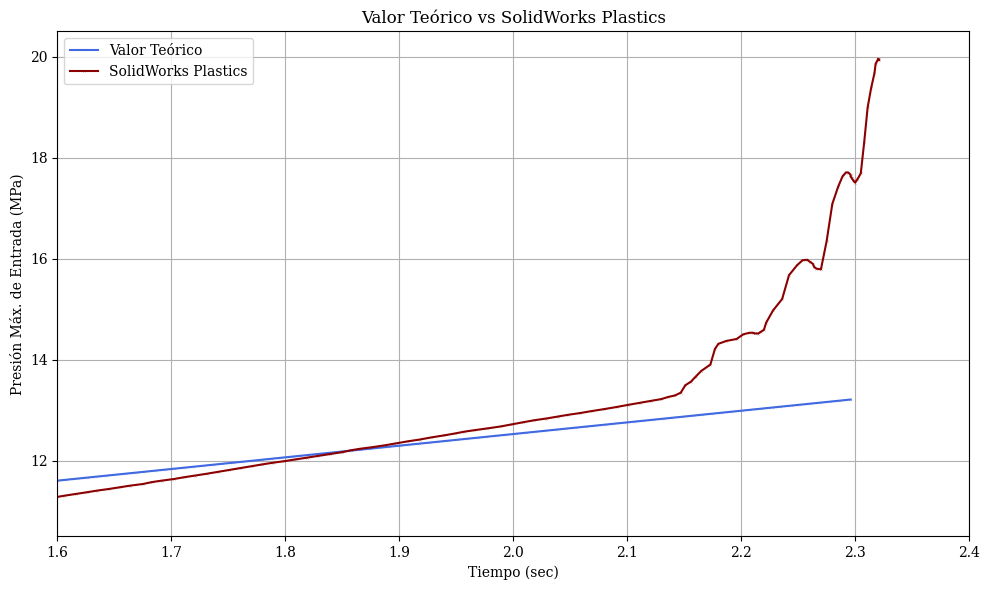

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths (update these as needed)
file_path1 = "Default-Presión Máx. de Entrada (MPa).csv"
file_path2 = "Valor teórico.csv"

# Read both CSVs
df1 = pd.read_csv(file_path1, encoding='latin1')
df2 = pd.read_csv(file_path2, encoding='latin1')

# Clean column names for both
df1.columns = [col.strip() for col in df1.columns]
df2.columns = [col.strip() for col in df2.columns]
df1.columns = ["Tiempo (sec)", "Presión Máx. de Entrada (MPa)"]
df2.columns = ["Tiempo (sec)", "Presión Máx. de Entrada (MPa)"]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df2["Tiempo (sec)"], df2["Presión Máx. de Entrada (MPa)"], 
         marker='x', linestyle='-', color='royalblue', markersize=1,
         markerfacecolor='firebrick', markeredgecolor='royalblue', markeredgewidth=.1, 
         label='Valor Teórico')
plt.plot(df1["Tiempo (sec)"], df1["Presión Máx. de Entrada (MPa)"], 
         marker='x', linestyle='-', color='darkred', markersize=2,
         markerfacecolor='blue', markeredgecolor='darkred', markeredgewidth=.1,
         label='SolidWorks Plastics')

plt.title("Valor Teórico vs SolidWorks Plastics")
plt.xlabel("Tiempo (sec)")
plt.ylabel("Presión Máx. de Entrada (MPa)")

# Set axis limits
plt.xlim(1.6, 2.40)  # Example: limit x-axis from 0 to 100 seconds
plt.ylim(10.5, 20.5)   # Example: limit y-axis from 0 to 10 MPa

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Solid plot TWO FILES zoom.png', dpi=100, bbox_inches='tight', transparent=False)
plt.show()

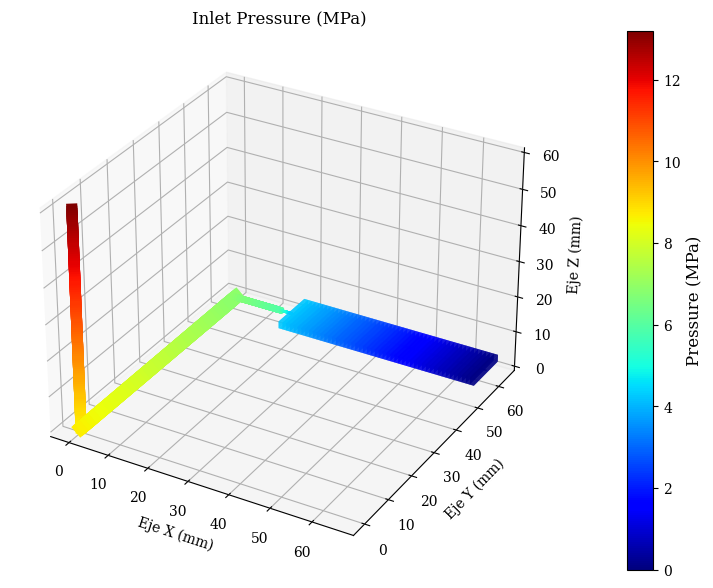

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Provided connecting points
x = [0, 0, 0, 12, 15, 65]
y = [0, 0, 63, 63, 63, 63]
z = [60, 0, 0, 0, 0, 0]

# Calculate pressure drops for each segment
pressure_drops = [
    pressure_sprue[-1],
    pressure_main_runner[-1],
    pressure_secondary_runner[-1],
    pressure_gate[-1],
    pressure_part[-1]
]

# Determine the maximum injection pressure
max_injection_pressure = sum(pressure_drops)

# Calculate the accumulated pressure at each point
accumulated_pressures = [max_injection_pressure]
for drop in pressure_drops:
    accumulated_pressures.append(accumulated_pressures[-1] - drop)

# Define radii for the first four sections
radii = [
    (r_in_sprue_mm + r_out_sprue_mm) / 2,  # Average radius for sprue
    r_main_runner_mm,                      # Radius for main runner
    r_secondary_runner_mm,                 # Radius for secondary runner
    (r_in_gate + r_out_gate) / 2           # Average radius for gate
]

# Part dimensions
part_width = 11.50
part_height = 2.00

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Normalize the accumulated pressure values for color mapping
norm = plt.Normalize(vmin=min(accumulated_pressures), vmax=max(accumulated_pressures))
cmap = plt.cm.jet

# Plot the path with gradient color based on accumulated pressure
for i in range(len(x) - 1):
    # Interpolate colors for the segment
    segment_x = np.linspace(x[i], x[i+1], 100)
    segment_y = np.linspace(y[i], y[i+1], 100)
    segment_z = np.linspace(z[i], z[i+1], 100)
    segment_pressure = np.linspace(accumulated_pressures[i], accumulated_pressures[i+1], 100)
    segment_colors = cmap(norm(segment_pressure))

    # Determine line width based on radius (scale for better visualization)
    if i < len(radii):
        line_width = radii[i] / max(radii) * 10  # Scale line width for visualization
    else:
        line_width = 1  # Default line width for the part

    # Plot each small segment with its color and line width
    for j in range(len(segment_x) - 1):
        ax.plot(segment_x[j:j+2], segment_y[j:j+2], segment_z[j:j+2], color=segment_colors[j], linewidth=line_width)

# Plot the rectangular part with gradient
part_start_index = 4
part_end_index = 5
part_x = [x[part_start_index], x[part_end_index]]
part_y = [y[part_start_index], y[part_end_index]]
part_z = [z[part_start_index], z[part_end_index]]

# Divide the part into 20 sections for gradient effect
num_sections = 50
for i in range(num_sections):
    # Calculate the start and end points for each section
    x_start = part_x[0] + (part_x[1] - part_x[0]) * i / num_sections
    x_end = part_x[0] + (part_x[1] - part_x[0]) * (i + 1) / num_sections

    # Define the corners of the section
    section_corners = np.array([
        [x_start, part_y[0] - part_width / 2, part_z[0] - part_height / 2],
        [x_start, part_y[0] + part_width / 2, part_z[0] - part_height / 2],
        [x_start, part_y[0] + part_width / 2, part_z[0] + part_height / 2],
        [x_start, part_y[0] - part_width / 2, part_z[0] + part_height / 2],
        [x_end, part_y[1] - part_width / 2, part_z[1] - part_height / 2],
        [x_end, part_y[1] + part_width / 2, part_z[1] - part_height / 2],
        [x_end, part_y[1] + part_width / 2, part_z[1] + part_height / 2],
        [x_end, part_y[1] - part_width / 2, part_z[1] + part_height / 2]
    ])

    # Define the faces of the section
    section_faces = [
        [section_corners[j] for j in [0, 1, 2, 3]],  # Front face
        [section_corners[j] for j in [4, 5, 6, 7]],  # Back face
        [section_corners[j] for j in [0, 1, 5, 4]],  # Bottom face
        [section_corners[j] for j in [2, 3, 7, 6]],  # Top face
        [section_corners[j] for j in [1, 2, 6, 5]],  # Right face
        [section_corners[j] for j in [0, 3, 7, 4]]   # Left face
    ]

    # Calculate the color for this section
    section_pressure = accumulated_pressures[part_start_index] - (accumulated_pressures[part_start_index] - accumulated_pressures[part_end_index]) * i / num_sections
    section_color = cmap(norm(section_pressure))

    # Create a Poly3DCollection for the section
    section_prism = Poly3DCollection(section_faces, facecolors=section_color, linewidths=0, edgecolors='none', alpha=0.7)
    ax.add_collection3d(section_prism)

# Add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.1)
cbar.set_label('Pressure (MPa)', fontsize=12)

# Set labels
ax.set_xlabel('Eje X (mm)')
ax.set_ylabel('Eje Y (mm)')
ax.set_zlabel('Eje Z (mm)')
ax.set_title('Inlet Pressure (MPa)')

plt.show()

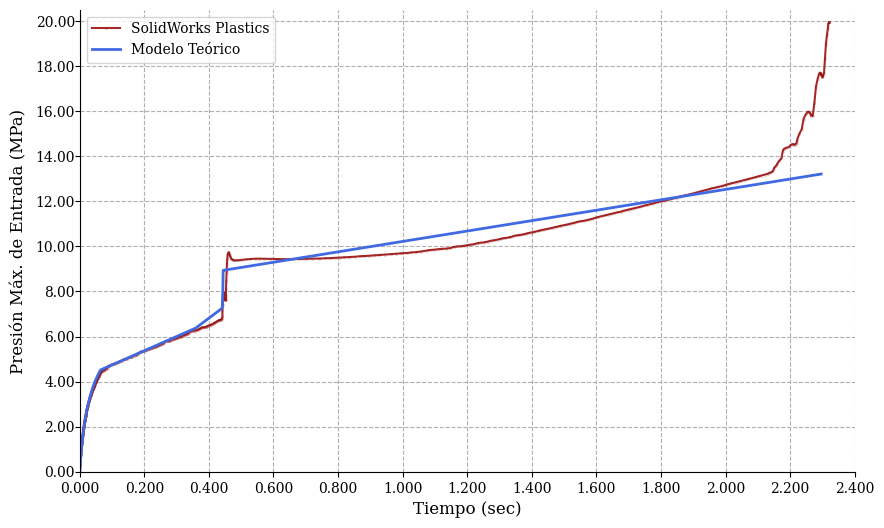

Pressure drop for sprue: 4.51 MPa
Pressure drop for main runner: 1.85 MPa
Pressure drop for secondary runner: 0.89 MPa
Pressure drop for gate: 1.69 MPa
Pressure drop for part: 4.27 MPa


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

def configure_matplotlib():
    plt.rcParams.update({
        "text.usetex": False,
        "font.family": "serif",
        "mathtext.fontset": "cm",
    })

def convert_units(Qcc_inlet, cavidades):
    return {
        'length_sprue_m': length_sprue_mm / 1000.0,
        'Q_m3_sprue': Qcc_inlet * 1e-6,
        'length_main_runner_m': length_main_runner_mm / 1000.0,
        'Q_m3_main_runner': (Qcc_inlet * 0.50 * (0.70/1.00)) * 1e-6,
        'length_secondary_runner_m': length_secondary_runner_mm / 1000.0,
        'Q_m3_secondary_runner': (Qcc_inlet / 20.0) * 1e-6,
        'length_gate_m': length_gate_mm / 1000.0,
        'Q_m3_gate': (Qcc_inlet / 20.0) * 1e-6,
        'length_part_m': length_part_mm / 1000.0,
        'Q_m3_part': (Qcc_inlet * 1e-6 / cavidades),
    }

def local_radius_mm_sprue(x, r_in_mm, r_out_mm, length_m):
    return r_in_mm + (r_out_mm - r_in_mm) * (x / length_m)

def local_radius_mm_runner(x, R_runner):
    return R_runner

def local_radius_mm_secondary_runner(x, R_secondary_runner):
    return R_secondary_runner

def local_radius_mm_gate(x, r_in_mm, r_out_mm, length_m):
    return r_in_mm + (r_out_mm - r_in_mm) * (x / length_m)

def calculate_pressure_and_time(Q_m3, length_m, local_radius_mm_func, params, is_part=False):
    x_array = np.linspace(0, length_m, N)
    dx = x_array[1] - x_array[0]
    time_array = np.zeros_like(x_array)
    pressure_array = np.zeros_like(x_array)

    for i in range(1, N):
        x_mid = 0.5 * (x_array[i-1] + x_array[i])
        if is_part:
            Wpart = (13.50 - 3.50) * 1e-3
            Hpart = 2.00 * 1e-3
            Lpart = length_m * 1e-3
            Qpart = Q_m3
            dP = 2 * k_sprue * (Lpart / Hpart) * (2 * (2 + (1 / n_sprue)) * Qpart / (Wpart * Hpart**2)) ** n_sprue
            dt = dx / (Qpart / (Wpart * Hpart))
        else:
            R_mid_mm = local_radius_mm_func(x_mid, **params)
            R_mid_m = R_mid_mm / 1000.0
            A_mid = np.pi * (R_mid_m)**2
            v_mid = Q_m3 / A_mid
            dt = dx / v_mid
            dx_mm = dx * 1000.0
            term = ((3 + 1/n_sprue) * Q_m3) / (np.pi * (R_mid_mm * 1e-3)**3)
            dP = 2 * k_sprue * (dx_mm / R_mid_mm) * (term ** n_sprue)
        time_array[i] = time_array[i-1] + dt
        pressure_array[i] = pressure_array[i-1] + dP

    pressure_array_MPa = pressure_array * 1e-6
    return time_array, pressure_array_MPa

def plot_pressure_vs_time(time_combined, pressure_combined, df=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    # Plot CSV data if provided
    if df is not None:
        ax.plot(df["Tiempo (sec)"], df["Presión Máx. de Entrada (MPa)"],
                marker='o', linestyle='-', color='brown', markersize=.1,
                markerfacecolor='firebrick', markeredgecolor='darkred', markeredgewidth=2,
                label='SolidWorks Plastics')
    ax.set_xlabel('Tiempo (sec)', fontsize=12, labelpad=4)
    ax.set_ylabel('Presión Máx. de Entrada (MPa)', fontsize=12, labelpad=6)
    ax.set_xlim(0, 2.4)
    ax.set_ylim(0, 20.5)
    ax.set_xticks(np.arange(0, 2.5, 0.2))
    ax.set_yticks(np.arange(0, 20.5, 2.0))
    ax.grid(True, linestyle='--')
    # Plot calculated curve
    ax.plot(time_combined, pressure_combined, lw=2, label='Modelo Teórico', color='royalblue')
    ax.legend()
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', pad=0)
    
    plt.savefig('SW vs python.png', dpi=100, bbox_inches='tight', transparent=False)
    plt.show()

# --- Constants ---
Qcc_inlet = 21.60
k_sprue = 5300
n_sprue = 0.378
length_sprue_mm = 60.00
r_in_sprue_mm = 4.00 / 2.0
r_out_sprue_mm = 6.75 / 2.0
length_main_runner_mm = 63.00
r_main_runner_mm = 3.35
length_secondary_runner_mm = 12.00
r_secondary_runner_mm = 1.54
length_gate_mm = 3.00
p_in_gate_mm = 4.66
p_out_gate_mm = 3.00
length_part_mm = 100.00
N = 1000
cavidades = 20

# --- Configure matplotlib ---
configure_matplotlib()

# --- Convert units ---
units = convert_units(Qcc_inlet, cavidades)

# --- Calculate for each section ---
params_sprue = {'r_in_mm': r_in_sprue_mm, 'r_out_mm': r_out_sprue_mm, 'length_m': units['length_sprue_m']}
time_sprue, pressure_sprue = calculate_pressure_and_time(units['Q_m3_sprue'], units['length_sprue_m'], local_radius_mm_sprue, params_sprue)
params_main_runner = {'R_runner': r_main_runner_mm}
time_main_runner, pressure_main_runner = calculate_pressure_and_time(units['Q_m3_main_runner'], units['length_main_runner_m'], local_radius_mm_runner, params_main_runner)
params_secondary_runner = {'R_secondary_runner': r_secondary_runner_mm}
time_secondary_runner, pressure_secondary_runner = calculate_pressure_and_time(units['Q_m3_secondary_runner'], units['length_secondary_runner_m'], local_radius_mm_secondary_runner, params_secondary_runner)
r_in_gate = p_in_gate_mm / (2 * np.pi)
r_out_gate = p_out_gate_mm / (2 * np.pi)
params_gate = {'r_in_mm': r_in_gate, 'r_out_mm': r_out_gate, 'length_m': units['length_gate_m']}
time_gate, pressure_gate = calculate_pressure_and_time(units['Q_m3_gate'], units['length_gate_m'], local_radius_mm_gate, params_gate)
time_part, pressure_part = calculate_pressure_and_time(units['Q_m3_part'], units['length_part_m'], None, None, is_part=True)

# --- Concatenate all data ---
time_combined = np.concatenate((
    time_sprue,
    time_sprue[-1] + time_main_runner,
    time_sprue[-1] + time_main_runner[-1] + time_secondary_runner,
    time_sprue[-1] + time_main_runner[-1] + time_secondary_runner[-1] + time_gate,
    time_sprue[-1] + time_main_runner[-1] + time_secondary_runner[-1] + time_gate[-1] + time_part
))
pressure_combined = np.concatenate((
    pressure_sprue,
    pressure_sprue[-1] + pressure_main_runner,
    pressure_sprue[-1] + pressure_main_runner[-1] + pressure_secondary_runner,
    pressure_sprue[-1] + pressure_main_runner[-1] + pressure_secondary_runner[-1] + pressure_gate,
    pressure_sprue[-1] + pressure_main_runner[-1] + pressure_secondary_runner[-1] + pressure_gate[-1] + pressure_part
))

# --- Load CSV data ---
file_path = "Default-Presión Máx. de Entrada (MPa).csv"
df = pd.read_csv(file_path, encoding='latin1')
df.columns = [col.strip() for col in df.columns]
df.columns = ["Tiempo (sec)", "Presión Máx. de Entrada (MPa)"]

# --- Plot both curves together ---
plot_pressure_vs_time(time_combined, pressure_combined, df=df)

# --- Print pressure drops (optional, as before) ---
params_sprue = {'r_in_mm': r_in_sprue_mm, 'r_out_mm': r_out_sprue_mm, 'length_m': units['length_sprue_m']}
time_sprue, pressure_sprue = calculate_pressure_and_time(units['Q_m3_sprue'], units['length_sprue_m'], local_radius_mm_sprue, params_sprue)
print(f"Pressure drop for sprue: {pressure_sprue[-1]:.2f} MPa")
accumulated_pressure_sprue = pressure_sprue[-1]
params_main_runner = {'R_runner': r_main_runner_mm}
time_main_runner, pressure_main_runner = calculate_pressure_and_time(units['Q_m3_main_runner'], units['length_main_runner_m'], local_radius_mm_runner, params_main_runner)
print(f"Pressure drop for main runner: {pressure_main_runner[-1]:.2f} MPa")
accumulated_pressure_main_runner = accumulated_pressure_sprue
params_secondary_runner = {'R_secondary_runner': r_secondary_runner_mm}
time_secondary_runner, pressure_secondary_runner = calculate_pressure_and_time(units['Q_m3_secondary_runner'], units['length_secondary_runner_m'], local_radius_mm_secondary_runner, params_secondary_runner)
print(f"Pressure drop for secondary runner: {pressure_secondary_runner[-1]:.2f} MPa")
accumulated_pressure_secondary_runner = accumulated_pressure_main_runner + pressure_secondary_runner[-1]
r_in_gate = p_in_gate_mm / (2 * np.pi)
r_out_gate = p_out_gate_mm / (2 * np.pi)
params_gate = {'r_in_mm': r_in_gate, 'r_out_mm': r_out_gate, 'length_m': units['length_gate_m']}
time_gate, pressure_gate = calculate_pressure_and_time(units['Q_m3_gate'], units['length_gate_m'], local_radius_mm_gate, params_gate)
print(f"Pressure drop for gate: {pressure_gate[-1]:.2f} MPa")
accumulated_pressure_gate = accumulated_pressure_secondary_runner + pressure_gate[-1]
time_part, pressure_part = calculate_pressure_and_time(units['Q_m3_part'], units['length_part_m'], None, None, is_part=True)
print(f"Pressure drop for part: {pressure_part[-1]:.2f} MPa")
accumulated_pressure_part = accumulated_pressure_gate + pressure_part[-1]